In [1]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import stable_baselines3
import time

In [2]:
# Print Versioning
print("Gym version", gym.__version__)
print("Numpy version", np.__version__)
print("Stable Baselines3 version", stable_baselines3.__version__)

Gym version 1.1.1
Numpy version 2.2.5
Stable Baselines3 version 2.6.0


In [3]:
# Set initial condition function here
def getInitialCondition(X, nx):
    xScale = np.linspace(0, X, nx)
    c0 = 0.8 * 1e5 * np.exp(-0.25 * (xScale ** 2))
    return c0

In [4]:
# Timestep and spatial step for PDE Solver
T = 600
X = 200
dt = 1
dx = 1

In [5]:
from pde_control_gym.src import BrainTumorReward

radiation_schedule = {
  'total_therapy_days': 34,
  't2_therapy_days': 28,
  'dose_gy': 1.8,
  'days_on_off': [True, True, True, True, True, False, False]
}

Parameters = {
  "T": T,
  "X": X,
  "dt": dt,
  "dx": dx,
  "reward_class": BrainTumorReward,
  "D": 0.2,
  "rho": 0.03,
  "alpha": 0.04,
  "alpha_beta_ratio": 10,
  "k": 1e5,
  "t1_detection_radius": 15,
  "t1_death_radius": 35,
  "reset_init_condition_func": getInitialCondition,
  "radiation_schedule": radiation_schedule
}

In [6]:
def runSingleEpisode(model, env, parameter):
    # Run entire cancer tumor progression
    terminate = False
    truncate = False

    # Holds the resulting states
    uStorage = []
    rew = 0

    # Reset Environment
    obs,__ = env.reset()
    uStorage.append(obs)

    while not truncate and not terminate:
        # use backstepping controller
        action = model(obs, parameter)
        obs, rewards, terminate, truncate, info = env.step(action)
        uStorage.append(obs)
        rew += rewards 
    u = np.array(uStorage)
    return rew, u


def openLoopController(_, _a):
    return 0

In [7]:
envOpenLoop = gym.make("PDEControlGym-BrainTumor1D", **Parameters)

nx: 201, nt: 601


In [8]:
rewOpenLoop, uOpenLoop = runSingleEpisode(openLoopController, envOpenLoop, _)

Growth: Perform dimensionalized finite differencing for time_index=1
Growth: Perform dimensionalized finite differencing for time_index=2
Growth: Perform dimensionalized finite differencing for time_index=3
Growth: Perform dimensionalized finite differencing for time_index=4
Growth: Perform dimensionalized finite differencing for time_index=5
Growth: Perform dimensionalized finite differencing for time_index=6
Growth: Perform dimensionalized finite differencing for time_index=7
Growth: Perform dimensionalized finite differencing for time_index=8
Growth: Perform dimensionalized finite differencing for time_index=9
Growth: Perform dimensionalized finite differencing for time_index=10
Growth: Perform dimensionalized finite differencing for time_index=11
Growth: Perform dimensionalized finite differencing for time_index=12
Growth: Perform dimensionalized finite differencing for time_index=13
Growth: Perform dimensionalized finite differencing for time_index=14
Growth: Perform dimensionaliz

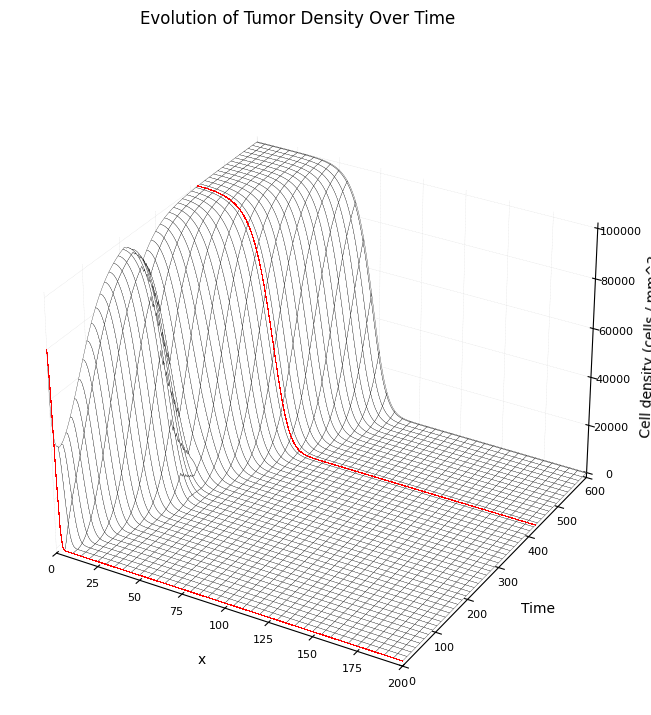

In [9]:
def plot3D(data, env):
    fig = plt.figure(figsize=(16, 8))
    fig.suptitle(f"Evolution of Tumor Density Over Time", fontsize=12)
    ax = fig.add_subplot(projection='3d')

    spatial = np.linspace(0, X, int(round(X/dx)+1))
    # adjust temporal to fit number of simulation days
    temporal = np.linspace(0, T, int(round(T/dt)+1))
    # cut data if needed to fit temporal domain length
    dataCut = data
    
    meshx, mesht = np.meshgrid(spatial, temporal)

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
      axis._axinfo['axisline']['linewidth'] = 1
      axis._axinfo['axisline']['color'] = "b"
      axis._axinfo['grid']['linewidth'] = 0.2
      axis._axinfo['grid']['linestyle'] = "--"
      axis._axinfo['grid']['color'] = "#d1d1d1"
      axis.set_pane_color((1,1,1))

    ax.set_xlabel("x", labelpad=5)
    ax.set_ylabel("Time", labelpad=5)
    ax.set_zlabel("Cell density (cells / mm^3", labelpad=5)
    ax.tick_params(axis='x', which='major', labelsize=8, pad=-2)
    ax.tick_params(axis='y', which='major', labelsize=8, pad=-2)
    ax.tick_params(axis='z', which='major', labelsize=8, pad=2)
    ax.set_xlim(0, X)
    ax.set_ylim(0, T)

    ax.view_init(elev=30, azim=-60)

    # plot surface
    surf = ax.plot_surface(meshx, mesht, dataCut, edgecolor="black", lw=0.2, alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    
    # plot initial condition
    t0 = np.zeros_like(spatial)
    vals = dataCut[0]
    ax.plot(spatial, t0, vals, color="red", lw=0.1, antialiased=False, rasterized=False, zorder=10)

    # plot death day
    if (env.unwrapped.cDeathDay is not None):
      t_death = np.full_like(spatial, env.unwrapped.cDeathDay)
      vals = dataCut[env.unwrapped.cDeathDay]
      ax.plot(spatial, t_death, vals, color="red", lw=0.1, antialiased=False, rasterized=False, zorder=10)

plot3D(uOpenLoop, envOpenLoop)